In [136]:
# Autor: Mario
# Propósito del código: Realizar un modelo de regresion logistica
# Descripción y uso: Primero se realiza la lectura de datos, luego realizo una seleccion de variables dejando solo las mas influyentes en el modelo y
#  evitando correlaciones (columnas innecesarias), para finalmente realizar un ajuste de hiperparametros y obtener el modelo.
# Estado actual: En proceso (Tarda mucho en compilar el modelo y falta la evaluacion del mismo)

In [ ]:
#NO BORRAR ESTA CELDA!!!!!!!!!!!!!!!!

#Marca con un * al final las que ya estén solucionadas

#Solucionar:
#Hacer lectura de las particiones ya hechas en drive*
#No hay estudio de transformaciones: explica cuales haces y porque*
#Se evaluan los modelos con accuracy en vez de f1-score (se explica el porque en la memoria)
#No hay estudio de selección de variables. Si es necesario hacer una selección indicar que algoritmo de selección de variables usar.*
#Porque son innecesarias las columnas que eliminas?*

*Importo librerias necesarias*

In [ ]:
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

import matplotlib.pyplot as plt
import seaborn as sns

Lectura de ficheros

In [10]:
rutaTrain = os.path.join(os.getcwd(), "..", "..", "data", "P1", "train.parquet")
rutaVal = os.path.join(os.getcwd(), "..", "..", "data", "P1", "validation.parquet")
rutaTest = os.path.join(os.getcwd(), "..", "..", "data", "P1", "test.parquet")
train = pd.read_parquet(rutaTrain)
val = pd.read_parquet(rutaVal)
test = pd.read_parquet(rutaTest)
print(f'Train: {train.shape}')
print(f'Validation: {val.shape}')
print(f'Test: {test.shape}')

Train: (5490, 84)
Validation: (1177, 84)
Test: (1177, 84)


Elimino columnas innecesarias

In [19]:
train = train.drop(columns=["DATE","CATEGORY","METHOD","Peleador_A","Peleador_B",'TITLE_FIGHT', 'WOMEN'])
val = val.drop(columns=["DATE","CATEGORY","METHOD","Peleador_A","Peleador_B",'TITLE_FIGHT', 'WOMEN'])
test = test.drop(columns=["DATE","CATEGORY","METHOD","Peleador_A","Peleador_B",'TITLE_FIGHT', 'WOMEN'])

Separo en X e Y

In [20]:
train_x=train.drop(columns='WINNER')
train_y=train['WINNER']
val_x=train.drop(columns='WINNER')
val_y=train['WINNER']
test_x=train.drop(columns='WINNER')
test_y=train['WINNER']

In [96]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Calcular la matriz de correlación
correlation_matrix = train_x.corr(method='spearman')

# Definir umbral de correlación alta (por ejemplo, 0.85)
umbral = 0.80

# Obtener pares de variables con alta correlación (excluyendo la diagonal)
correlated_features = (
    correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool))
    .stack()
    .reset_index()
)

# Filtrar pares con correlación mayor al umbral
correlated_features.columns = ["Variable 1", "Variable 2", "Correlación"]
highly_correlated = correlated_features[abs(correlated_features["Correlación"]) > umbral]

# Mostrar las variables más correlacionadas
print("Variables altamente correlacionadas:\n", highly_correlated)


Variables altamente correlacionadas:
             Variable 1        Variable 2  Correlación
88               ROUND     TOTAL_STR_A_y     0.802468
446          TD_PORC_A            TD_A_x     0.874402
516          TD_PORC_B            TD_B_x     0.922550
959      TOTAL_STR_A_x     TOTAL_STR_A_y     0.937687
966      TOTAL_STR_A_x      STR_HEAD_A_x     0.820151
1026     TOTAL_STR_A_y      STR_HEAD_A_x     0.850698
1027     TOTAL_STR_A_y      STR_HEAD_A_y     0.912430
1039     TOTAL_STR_A_y  STR_DISTANCE_A_y     0.824552
1080     TOTAL_STR_B_x     TOTAL_STR_B_y     0.934115
1087     TOTAL_STR_B_x      STR_HEAD_B_x     0.844549
1145     TOTAL_STR_B_y      STR_HEAD_B_x     0.873005
1146     TOTAL_STR_B_y      STR_HEAD_B_y     0.931890
1156     TOTAL_STR_B_y  STR_DISTANCE_A_y     0.802379
1157     TOTAL_STR_B_y  STR_DISTANCE_B_x     0.849392
1158     TOTAL_STR_B_y  STR_DISTANCE_B_y     0.882628
1288            TD_A_y        GRAPPLER_A     0.872579
1398            TD_B_y        GRAPPLER_B    

Se observa alta correlacion entre las variables que tienen el numero de golpes tirados(X) y el numero de golpes conectados(Y).
Decido eliminar la segunda, evitando asi la correlacion entre variables del modelo.

In [99]:
train_x2=train_x.drop(columns=highly_correlated['Variable 2'])
val_x2=val_x.drop(columns=highly_correlated['Variable 2'])
test_x2=test_x.drop(columns=highly_correlated['Variable 2'])


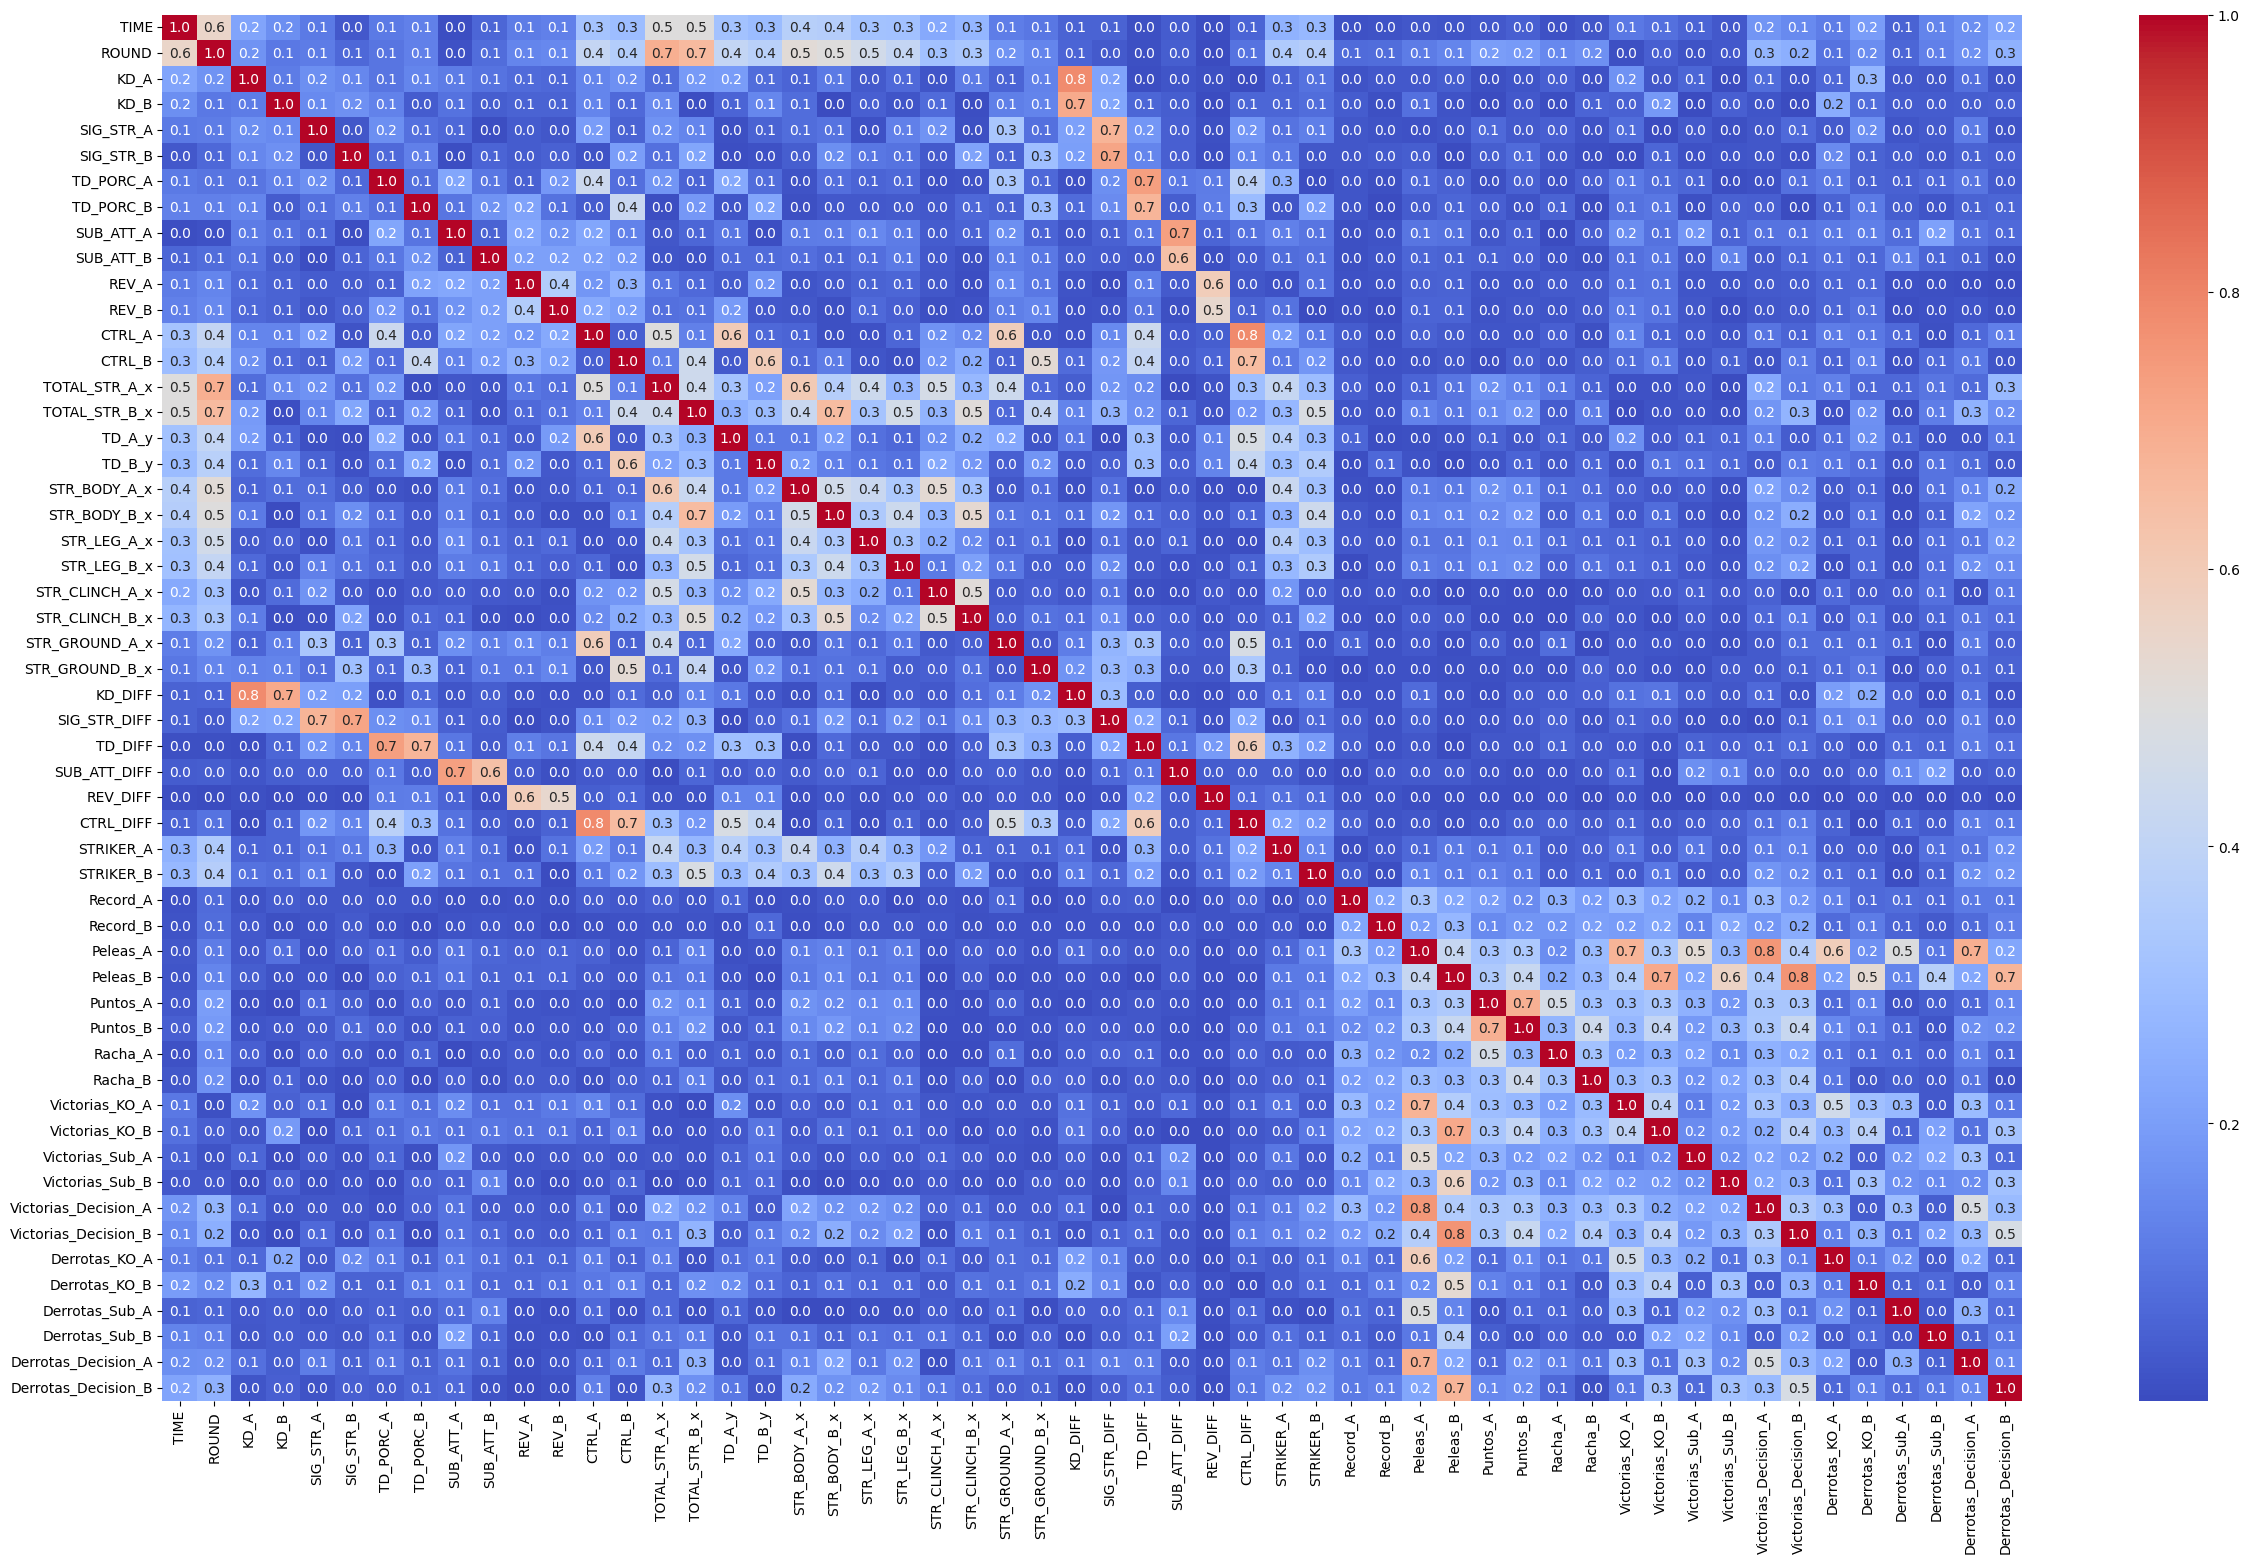

In [101]:
plt.figure(figsize=(30, 18))
sns.heatmap(train_x2.corr().abs(), annot=True, cmap="coolwarm", fmt=".1f")
plt.show()

Se observa como ya no hay variables altamente correlacionadas entre si

*Transformaciones*

Para facilitar la convergencia del modelo, reducir los riesgos de sesgo y posteriormente poder comparar los coeficientes vamos a realizar un escalado robusto. Elegimos este tipo de escalado porque los datos no siguen distribuciones normales y tienen mucha presencia de datos atípicos. 

In [85]:
from sklearn.preprocessing import RobustScaler


In [103]:
scaler = RobustScaler()
train_x3 = scaler.fit_transform(train_x2)
val_x3 = scaler.transform(val_x2)
test_x3 = scaler.transform(test_x2)

In [102]:
train_x2.describe()

,TIME,KD_A,KD_B,SIG_STR_A,SIG_STR_B,TD_PORC_A,TD_PORC_B,SUB_ATT_A,SUB_ATT_B,REV_A,...,Victorias_Sub_A,Victorias_Sub_B,Victorias_Decision_A,Victorias_Decision_B,Derrotas_KO_A,Derrotas_KO_B,Derrotas_Sub_A,Derrotas_Sub_B,Derrotas_Decision_A,Derrotas_Decision_B
count,5490.000000,5490.000000,5490.000000,5490.000000,5490.000000,5490.000000,5490.000000,5490.000000,5490.000000,5490.00000,...,5490.000000,5490.000000,5490.000000,5490.000000,5490.000000,5490.000000,5490.000000,5490.000000,5490.000000,5490.000000
mean,227.611658,0.246995,0.185428,0.474093,0.435866,0.298880,0.231933,0.438069,0.333698,0.13898,...,0.976321,0.650273,2.124044,1.448816,0.781056,0.702732,0.502732,0.455191,1.334608,1.153916
std,92.425131,0.520849,0.458366,0.160498,0.170229,0.364121,0.336566,0.878214,0.777093,0.44418,...,1.552795,1.251017,2.281298,1.895720,1.149337,0.995971,0.924993,0.794575,1.629251,1.448386
min,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,154.000000,0.000000,0.000000,0.370000,0.330000,0.000000,0.000000,0.000000,0.000000,0.00000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,293.000000,0.000000,0.000000,0.470000,0.430000,0.050000,0.000000,0.000000,0.000000,0.00000,...,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000
75%,300.000000,0.000000,0.000000,0.570000,0.530000,0.500000,0.420000,1.000000,0.000000,0.00000,...,1.000000,1.000000,3.000000,2.000000,1.000000,1.000000,1.000000,1.000000,2.000000,2.000000
max,720.000000,5.000000,4.000000,1.000000,1.000000,1.000000,1.000000,10.000000,7.000000,6.00000,...,16.000000,14.000000,14.000000,13.000000,8.000000,8.000000,8.000000,6.000000,12.000000,12.000000


In [117]:
train_x3_df = pd.DataFrame(train_x3,columns=train_x2.columns)
val_x3_df = pd.DataFrame(val_x3,columns=val_x2.columns)
test_x3_df = pd.DataFrame(test_x3,columns=test_x2.columns)

train_x3_df.describe()

,TIME,ROUND,KD_A,KD_B,SIG_STR_A,SIG_STR_B,TD_PORC_A,TD_PORC_B,SUB_ATT_A,SUB_ATT_B,...,Victorias_Sub_A,Victorias_Sub_B,Victorias_Decision_A,Victorias_Decision_B,Derrotas_KO_A,Derrotas_KO_B,Derrotas_Sub_A,Derrotas_Sub_B,Derrotas_Decision_A,Derrotas_Decision_B
count,5490.000000,5490.000000,5490.000000,5490.000000,5490.000000,5490.000000,5490.000000,5490.000000,5490.000000,5490.000000,...,5490.000000,5490.000000,5490.000000,5490.000000,5490.000000,5490.000000,5490.000000,5490.000000,5490.000000,5490.000000
mean,-0.447865,-0.310109,0.246995,0.185428,0.020464,0.029329,0.497760,0.552220,0.438069,0.333698,...,0.976321,0.650273,0.374681,0.224408,0.781056,0.702732,0.502732,0.455191,0.167304,0.076958
std,0.633049,0.503638,0.520849,0.458366,0.802490,0.851143,0.728242,0.801348,0.878214,0.777093,...,1.552795,1.251017,0.760433,0.947860,1.149337,0.995971,0.924993,0.794575,0.814625,0.724193
min,-1.972603,-1.000000,0.000000,0.000000,-2.350000,-2.150000,-0.100000,0.000000,0.000000,0.000000,...,0.000000,0.000000,-0.333333,-0.500000,0.000000,0.000000,0.000000,0.000000,-0.500000,-0.500000
25%,-0.952055,-1.000000,0.000000,0.000000,-0.500000,-0.500000,-0.100000,0.000000,0.000000,0.000000,...,0.000000,0.000000,-0.333333,-0.500000,0.000000,0.000000,0.000000,0.000000,-0.500000,-0.500000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.047945,0.000000,0.000000,0.000000,0.500000,0.500000,0.900000,1.000000,1.000000,0.000000,...,1.000000,1.000000,0.666667,0.500000,1.000000,1.000000,1.000000,1.000000,0.500000,0.500000
max,2.924658,1.000000,5.000000,4.000000,2.650000,2.850000,1.900000,2.380952,10.000000,7.000000,...,16.000000,14.000000,4.333333,6.000000,8.000000,8.000000,8.000000,6.000000,5.500000,5.500000


Realizo un RFE con validación cruzada para seleccionar el número óptimo de variables.

In [108]:
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV


def aplicarRFECV(X, y):
    
    MIN_FEATURES = 5
    METRICA = "balanced_accuracy"

    # Modelo de regresión logística
    modelo = LogisticRegression(max_iter = 5000, class_weight="balanced")

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
   
    rfecv = RFECV(
        estimator=modelo,
        step=1,
        cv=cv,
        scoring=METRICA,
        min_features_to_select= MIN_FEATURES,
    )
    
    rfecv.fit(X, y)
    
    # Número óptimo de variables seleccionadas
    num_optimal_features = rfecv.n_features_
    print("Número óptimo de variables seleccionadas:", num_optimal_features)

    # Obtener índices de variables seleccionadas
    selected_feature_indices = rfecv.support_

    # Obtener nombres de variables seleccionadas
    selected_feature_names = [X.columns[i] for i, selected in enumerate(selected_feature_indices) if selected]
    
    # Tomado de https://scikit-learn.org/stable/auto_examples/feature_selection/plot_rfe_with_cross_validation.html#sphx-glr-auto-examples-feature-selection-plot-rfe-with-cross-validation-py
    n_scores = len(rfecv.cv_results_["mean_test_score"])
    plt.figure(figsize=(12, 6))
    plt.xlabel("Número de variables elegidas")
    plt.ylabel("Media balanced accuracy en test")
    plt.errorbar(
        range(MIN_FEATURES, n_scores + MIN_FEATURES),
        rfecv.cv_results_["mean_test_score"],
        yerr=rfecv.cv_results_["std_test_score"],
    )
    plt.title("RFE con validación cruzada")
    plt.show()
    
    return selected_feature_names

Número óptimo de variables seleccionadas: 41


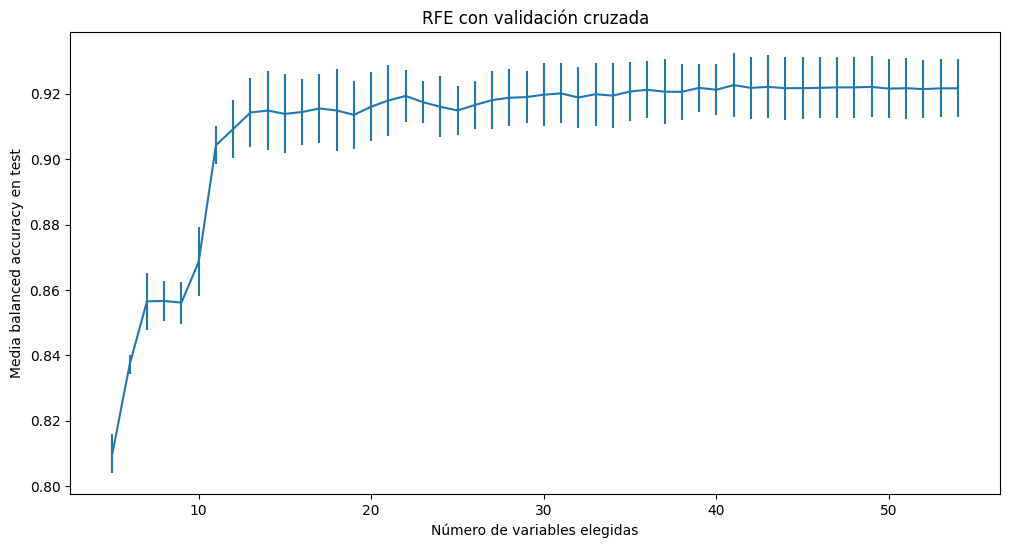

In [110]:
variablesElegidas = aplicarRFECV(train_x3_df, train_y)


In [114]:
variablesDescartadas = [v for v in train_x3_df.columns if v not in variablesElegidas]
print('Variables descartadas: ',variablesDescartadas)
print('Variables elegidas: ',variablesElegidas)

Variables descartadas:  ['SIG_STR_A', 'SUB_ATT_B', 'REV_A', 'CTRL_B', 'TD_A_y', 'TD_B_y', 'STR_BODY_B_x', 'STR_LEG_A_x', 'STR_LEG_B_x', 'STR_CLINCH_A_x', 'STR_CLINCH_B_x', 'Victorias_KO_B', 'Victorias_Sub_B']
Variables elegidas:  ['TIME', 'ROUND', 'KD_A', 'KD_B', 'SIG_STR_B', 'TD_PORC_A', 'TD_PORC_B', 'SUB_ATT_A', 'REV_B', 'CTRL_A', 'TOTAL_STR_A_x', 'TOTAL_STR_B_x', 'STR_BODY_A_x', 'STR_GROUND_A_x', 'STR_GROUND_B_x', 'KD_DIFF', 'SIG_STR_DIFF', 'TD_DIFF', 'SUB_ATT_DIFF', 'REV_DIFF', 'CTRL_DIFF', 'STRIKER_A', 'STRIKER_B', 'Record_A', 'Record_B', 'Peleas_A', 'Peleas_B', 'Puntos_A', 'Puntos_B', 'Racha_A', 'Racha_B', 'Victorias_KO_A', 'Victorias_Sub_A', 'Victorias_Decision_A', 'Victorias_Decision_B', 'Derrotas_KO_A', 'Derrotas_KO_B', 'Derrotas_Sub_A', 'Derrotas_Sub_B', 'Derrotas_Decision_A', 'Derrotas_Decision_B']


In [121]:
train_x4=train_x3_df.drop(columns=variablesDescartadas)
val_x4=val_x3_df.drop(columns=variablesDescartadas)
test_x4=test_x3_df.drop(columns=variablesDescartadas)

In [ ]:
def realizarGridSearchCV(estimador, param_grid, kf, X, y):
    """Realiza la estrategia de búsqueda Grid Search CV"""

    # Definimos la búsqueda en rejilla
    grid_search = GridSearchCV(estimator=estimador, param_grid=param_grid, cv=kf,
                            scoring=METRICS, refit = "balanced_accuracy", return_train_score=True, n_jobs=-1, error_score="raise")

    # Realizamos la exploración
    grid_search.fit(X, y)
    
    return grid_search

Ajuste hiperparametros

In [123]:
from sklearn.metrics import make_scorer

def sensitivity(y_true, y_pred):
    """Calcula la sensibilidad dados los valores verdaderos y los predichos"""
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return tp / (tp + fn)

# Función para calcular la especificidad
def specificity(y_true, y_pred):
    """Calcula la especificidad dados los valores verdaderos y los predichos"""
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return tn / (tn + fp)

def generarMetricas():
    """Genera un diccinario con las métricas empleadas para evaluar los modelos"""

    # Convierte las funciones en funciones de puntuación para usar en RandomizedSearchCV
    sensitivity_scorer = make_scorer(sensitivity)
    specificity_scorer = make_scorer(specificity)

    # Contiene las métricas con las que evaluar los modelos
    return {'balanced_accuracy': 'balanced_accuracy',
            'sensitivity': sensitivity_scorer,
            'specificity': specificity_scorer}

METRICS = generarMetricas()

In [130]:
from sklearn.model_selection import GridSearchCV

def realizarGridSearchCV(estimador, param_grid, kf, X, y):
    """Realiza la estrategia de búsqueda Grid Search CV"""

    # Definimos la búsqueda en rejilla
    grid_search = GridSearchCV(estimator=estimador, param_grid=param_grid, cv=kf,
                            scoring=METRICS, refit = "balanced_accuracy", return_train_score=True, n_jobs=-1, error_score="raise")

    # Realizamos la exploración
    grid_search.fit(X, y)
    
    return grid_search

In [133]:
param_grid = {
    'solver': ['saga'],
    'penalty': ['elasticnet'],
    'max_iter': [2000],
    'C': [0.00001, 0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0, 10000.0], 
    'l1_ratio': np.linspace(0.0, 1.0, 10),
    'fit_intercept': [True, False]
}

# Realizamos la exploración
modelo = LogisticRegression()

grid_search = realizarGridSearchCV(modelo, param_grid, 5, train_x4, train_y)

# Resultados
cv_results = grid_search.cv_results_
best_params = grid_search.best_params_

c:\Users\Mario\Documents\GitHub\c2425-R4\.venv\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Modelo